In [66]:
# Utility 
import os
import tqdm
from typing import List

# Data manipulation
import pandas as pd
import numpy as np

# Scientific
from scipy.sparse import hstack

# Machine learning
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

In [4]:
bodies = pd.read_csv("../data/bodies.csv", )
stances = pd.read_csv("../data/stances.csv")

In [5]:
bodies = bodies.rename(columns={"Body ID": "body_id", "articleBody": "article_body"})
stances = stances.rename(columns={"Body ID": "body_id"})
stances.columns = stances.columns.str.lower()

In [6]:
bodies.head()

,body_id,article_body
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [7]:
stances.head()

,headline,body_id,stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [8]:
print("Bodies shape")
bodies.shape

Bodies shape


(1683, 2)

In [9]:
print("Stances shape")
stances.shape

Stances shape


(49972, 3)

In [10]:
stances_uniqe_body_ids = np.unique(stances.body_id.values)

In [11]:
print("Matching body_ids?")
sorted(bodies.body_id.values) == sorted(stances_uniqe_body_ids)

Matching body_ids?


True

In [12]:
print(f"Unique stances: {np.unique(stances.stance)}")

Unique stances: ['agree' 'disagree' 'discuss' 'unrelated']


In [13]:
df = pd.merge(bodies, stances, on="body_id")

In [14]:
print("Class split in the dataset")
df['stance'].value_counts()

Class split in the dataset


unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: stance, dtype: int64

In [15]:
print("Class split in the dataset (% of all labels)")
df['stance'].value_counts(normalize=True) * 100

Class split in the dataset (% of all labels)


unrelated    73.130953
discuss      17.827984
agree         7.360122
disagree      1.680941
Name: stance, dtype: float64

In [16]:
df

,body_id,article_body,headline,stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated
...,...,...,...,...
49967,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00...",agree
49968,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip",agree
49969,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip",agree
49970,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...,agree


In [17]:
mappings = { key: "related" for key in ["agree", "disagree", "discuss"]}
mappings.update({"unrelated": "unrelated"})
df["relation"] = df.apply(lambda row: mappings[row["stance"]], axis=1)
df

,body_id,article_body,headline,stance,relation
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated,unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated,unrelated
...,...,...,...,...,...
49967,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00...",agree,related
49968,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip",agree,related
49969,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip",agree,related
49970,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...,agree,related


In [18]:
print("Class split for relation analysis")
df['relation'].value_counts()

Class split for relation analysis


unrelated    36545
related      13427
Name: relation, dtype: int64

In [19]:
print("Class split for relation analysis (% of all labels)")
df['relation'].value_counts(normalize=True) * 100

Class split for relation analysis (% of all labels)


unrelated    73.130953
related      26.869047
Name: relation, dtype: float64

In [20]:
example_unrelated = df[df["relation"] == "unrelated"].first_valid_index()
example_related = df[df["relation"] == "related"].first_valid_index()

In [21]:
def formatted_print(df, idx):
    data = df.iloc[idx]
    print(f"Headline-Body relation: {data.relation.capitalize()}")
    print("---")
    print(data.headline)
    print("---")
    print(data.article_body)

In [22]:
formatted_print(df, example_unrelated)

Headline-Body relation: Unrelated
---
Soldier shot, Parliament locked down after gunfire erupts at war memorial
---
A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports. 

Government spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth." House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. 
Murillo said Nicaragua will ask international experts to help local scientists in understanding what happened.

The crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies wh

In [23]:
formatted_print(df, example_related)

Headline-Body relation: Related
---
Small Meteorite Strikes in Nicaragua's Capital City of Managua
---
A small meteorite crashed into a wooded area in Nicaragua's capital of Managua overnight, the government said Sunday. Residents reported hearing a mysterious boom that left a 16-foot deep crater near the city's airport, the Associated Press reports. 

Government spokeswoman Rosario Murillo said a committee formed by the government to study the event determined it was a "relatively small" meteorite that "appears to have come off an asteroid that was passing close to Earth." House-sized asteroid 2014 RC, which measured 60 feet in diameter, skimmed the Earth this weekend, ABC News reports. 
Murillo said Nicaragua will ask international experts to help local scientists in understanding what happened.

The crater left by the meteorite had a radius of 39 feet and a depth of 16 feet,  said Humberto Saballos, a volcanologist with the Nicaraguan Institute of Territorial Studies who was on the 

In [24]:
df = df.drop(columns="body_id")
df

,article_body,headline,stance,relation
0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated,unrelated
1,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated,unrelated
2,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated,unrelated
3,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated,unrelated
4,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated,unrelated
...,...,...,...,...
49967,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00...",agree,related
49968,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip",agree,related
49969,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip",agree,related
49970,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...,agree,related


In [25]:
X, y = df[["article_body", "headline"]], df[["stance", "relation"]]
X

,article_body,headline
0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun..."
1,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...
2,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...
3,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa
4,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...
...,...,...
49967,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00..."
49968,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip"
49969,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip"
49970,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...


In [26]:
y

,stance,relation
0,unrelated,unrelated
1,unrelated,unrelated
2,unrelated,unrelated
3,unrelated,unrelated
4,unrelated,unrelated
...,...,...
49967,agree,related
49968,agree,related
49969,agree,related
49970,agree,related


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [83]:
y_train.shape, y_test.shape

((39977, 2), (9995, 2))

In [30]:
y_train

,stance,relation
32196,discuss,related
42226,unrelated,unrelated
45726,unrelated,unrelated
44791,unrelated,unrelated
29751,unrelated,unrelated
...,...,...
2760,unrelated,unrelated
49091,unrelated,unrelated
7408,unrelated,unrelated
37429,disagree,related


In [31]:
y_train_rel = np.array(y_train["relation"])
y_train_rel = np.where(y_train_rel == "related", 1, 0)

y_test_rel = np.array(y_test["relation"])
y_test_rel = np.where(y_test_rel == "related", 1, 0)

y_train_cls = y_train["stance"] != "unrelated"
y_test_cls = y_test["stance"] != "unrelated"

y_train_cls_indices = y_train_cls[y_train_cls].index
y_test_cls_indices = y_test_cls[y_test_cls].index

y_train_cls = np.array(y_train.loc[y_train_cls].drop(columns=["relation"])).ravel()
y_test_cls = np.array(y_test.loc[y_test_cls].drop(columns=["relation"])).ravel()

label_encoder = LabelEncoder()
y_train_cls = label_encoder.fit_transform(y_train_cls)
y_test_cls = label_encoder.fit_transform(y_test_cls)
cls_labels = label_encoder.classes_
cls_labels

array(['agree', 'disagree', 'discuss'], dtype=object)

In [32]:
X_train_cls = X_train.loc[y_train_cls_indices]
X_test_cls = X_test.loc[y_test_cls_indices]

In [33]:
class TFIDFTransform:
    def __init__(self, headline_vectorizer, body_vectorizer):
        self._headline_vectorizer = headline_vectorizer
        self._body_vectorizer = body_vectorizer


    def fit_transform(self, df):
        headline, body = df["headline"], df["article_body"]

        X_headline = self._headline_vectorizer.fit_transform(headline)
        X_body = self._body_vectorizer.fit_transform(body)

        X = hstack((X_headline, X_body))
        return X

    def transform(self, df):
        headline, body = df["headline"], df["article_body"]

        X_headline = self._headline_vectorizer.transform(headline)
        X_body = self._body_vectorizer.transform(body)

        X = hstack((X_headline, X_body))
        return X

In [34]:
headline_vectorizer = TfidfVectorizer(analyzer="word", stop_words="english", lowercase=True, token_pattern=r"\w+")
body_vectorizer = TfidfVectorizer(analyzer="word", stop_words="english", lowercase=True, token_pattern=r"\w+")

tfidf_transform = TFIDFTransform(headline_vectorizer=headline_vectorizer, body_vectorizer=body_vectorizer)

In [35]:
X_train_rel_vec = tfidf_transform.fit_transform(X_train)
X_train_cls_vec = tfidf_transform.transform(X_train_cls)
X_test_rel_vec = tfidf_transform.transform(X_test)
X_test_cls_vec = tfidf_transform.transform(X_test_cls)

In [36]:
X_train_rel_vec.shape

(39977, 26001)

In [37]:
X_test_rel_vec.shape

(9995, 26001)

In [38]:
D_train_rel = xgb.DMatrix(X_train_rel_vec, label=y_train_rel)
D_test_rel = xgb.DMatrix(X_test_rel_vec, label=y_test_rel)

D_train_cls = xgb.DMatrix(X_train_cls_vec, label=y_train_cls)
D_test_cls = xgb.DMatrix(X_test_cls_vec, label=y_test_cls)

In [39]:
y_train_cls.shape

(10769,)

In [40]:
y_train_rel.shape

(39977,)

In [76]:
def print_metrics(y_true: np.ndarray | List[int], y_pred: np.ndarray | List[int], average: str="binary") -> None:
    print("Precision = {}".format(precision_score(y_true, y_pred, average=average)))
    print("Recall = {}".format(recall_score(y_true, y_pred, average=average)))
    print("Accuracy = {}".format(accuracy_score(y_true, y_pred)))
    print("Balanced accuracy = {}".format(balanced_accuracy_score(y_true, y_pred)))

def plot_cm(y_true: np.ndarray | List[int], y_pred: np.ndarray | List[int], labels: List[str]) -> None:
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=labels)
    disp.plot()

(10688,)

In [68]:
param = {
    'eta': 0.3, 
    'max_depth': 12
    } 

steps = 100  # The number of training iterations

In [69]:
rel_classifier = xgb.train(param, D_train_rel, steps)

In [74]:
rel_pred = rel_classifier.predict(D_test_rel)
rel_pred = np.where(rel_pred < 0.5, 0, 1)

print_metrics(y_test_rel, rel_pred)

Precision = 0.9844961240310077
Recall = 0.9078254326561325
Accuracy = 0.9716858429214608
Balanced accuracy = 0.951323102044299


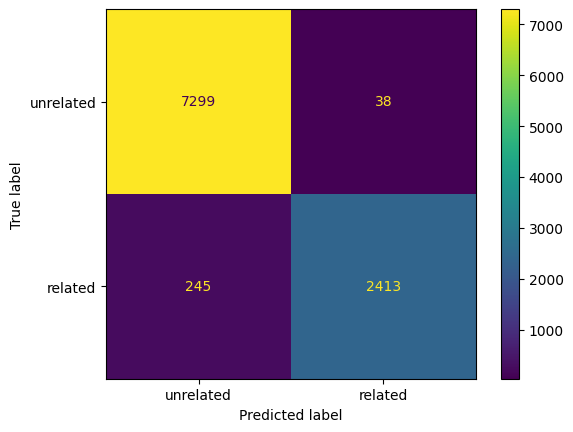

In [78]:
plot_cm(y_test_rel, rel_pred, labels=["unrelated", "related"])

In [59]:
param_cls = {
    'eta': 0.3, 
    'max_depth': 20,
    'num_class': 3
    } 

steps = 100  # The number of training iterations

In [64]:
cls_classifier = xgb.train(param_cls, D_train_cls, steps)

In [81]:
cls_pred = cls_classifier.predict(D_test_cls)
print_metrics(y_test_cls, cls_pred, average="macro")

Precision = 0.8936086406010425
Recall = 0.8731588057927628
Accuracy = 0.9428141459744168
Balanced accuracy = 0.8731588057927628


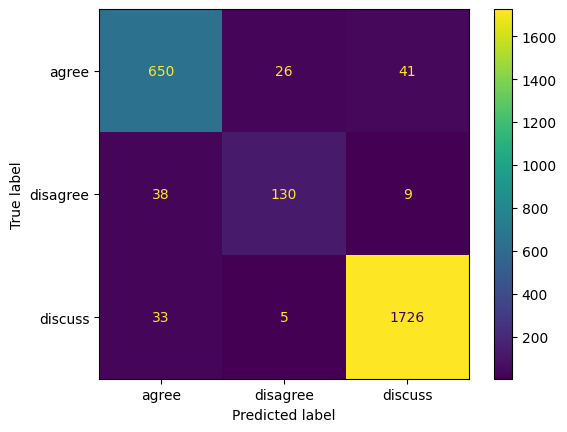

In [82]:
plot_cm(y_test_cls, cls_pred, labels=cls_labels)

In [53]:
# Dodac pipeline